# Verification of the pipeline on MXNet

In [2]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Network : UNET

In [5]:
from mxnet.symbol import Variable, Convolution, Deconvolution, BatchNorm, Pooling, Activation, LeakyReLU, concat

In [9]:
def base_conv(x, n_filters, s_id=""):    
    x = Convolution(data=x, 
                    num_filter=n_filters, 
                    kernel=(3, 3), 
                    pad=(1, 1), 
                    name="%s_conv" % s_id)
    x = BatchNorm(data=x, name="%s_bn" % s_id)
    return LeakyReLU(data=x, act_type='elu', slope=0.25, name="%s_act" % s_id)


def encoder(inputs, n_filters, depth=5):
    list_encoder = []
    list_nb_filters = []
    temp_layers = [inputs]
    for i in range(depth):
        nf = n_filters * 2**i
        x = base_conv(temp_layers[-1], nf, s_id="encoder_%ia" % i)
        x = base_conv(x, nf, s_id="encoder_%ib" % i)
        list_encoder.append(x)
        list_nb_filters.append(nf)
        x = Pooling(data=x, kernel=(2, 2), pool_type="max", name="encoder_%i_pool" % i)
        temp_layers.append(x)

    i = depth
    nf = n_filters * 2**i
    x = base_conv(temp_layers[-1], nf, s_id="encoder_%ia" % i)
    x = base_conv(x, nf, s_id="encoder_%ib" % i)
    list_encoder.append(x)
    return list_encoder, list_nb_filters


def decoder(list_encoder, list_nb_filters):
    l = len(list_encoder)
    temp_layers = [list_encoder[l-1]]
    for i in range(l-1):
        x = Deconvolution(data=temp_layers[-1], 
                          num_filter=list_nb_filters[l-i-2],
                          kernel=(4, 4), 
                          adj=(1, 1),
                          stride=(2, 2), name="decoder_%i_deconv" % i)
        
        x = concat(x, list_encoder[l-i-2], dim=1, name="decoder_%i_concat" % i)                
        x = base_conv(x, list_nb_filters[l-i-2], s_id="decoder_%ia" % i)
        x = base_conv(x, list_nb_filters[l-i-2], s_id="decoder_%ib" % i)
        temp_layers.append(x)

    return temp_layers[-1]
    

In [11]:
input_shape = (512, 512, 3)
n_classes = 1
depth = 2
n_filters = 32

inputs = Variable(name="data", shape=input_shape)

list_encoder, list_nb_filters = encoder(inputs, n_filters, depth=depth)
x = decoder(list_encoder, list_nb_filters) 

x = Convolution(data=x, 
                num_filter=n_classes, 
                kernel=(1, 1), 
                name="output_conv")
outputs = Activation(data=x, act_type="sigmoid", name="output_proba")



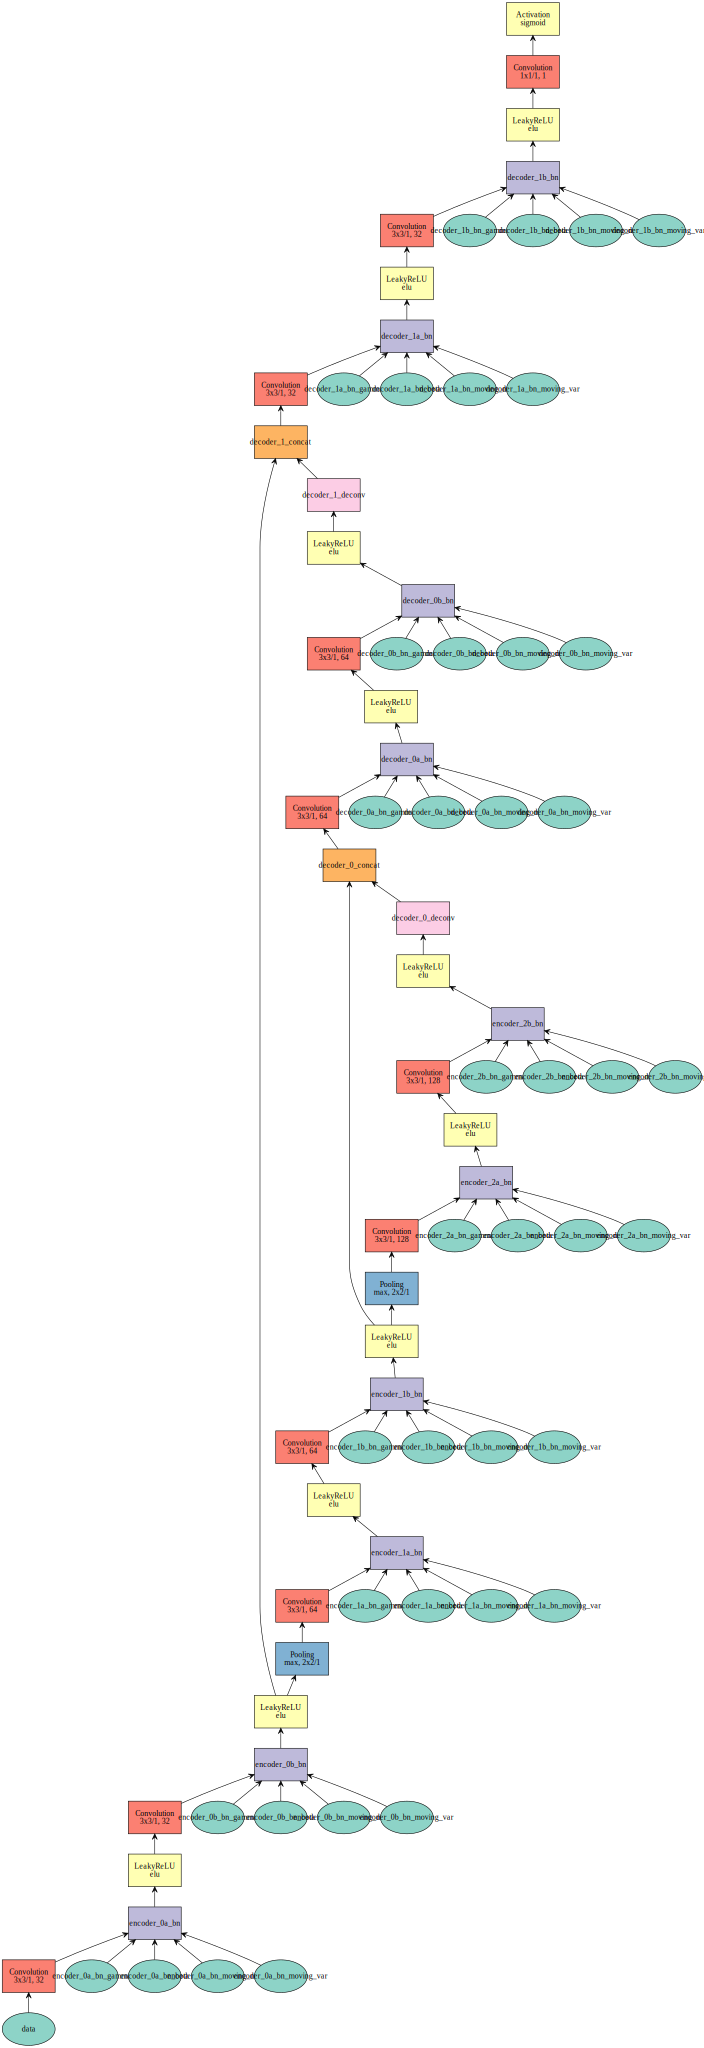

In [14]:
import mxnet as mx
# Visualize your network
mx.viz.plot_network(outputs)